In [34]:
from data_formats import read_data
from dose_reponse_fit import dose_response_fit, StandardSettings
import matplotlib.pyplot as plt
from plotting import *
from stress_survival_conversion import stress_to_survival, survival_to_stress
import random
import glob
import pandas as pd
from tqdm import tqdm
from scipy.stats import beta, gamma, expon, weibull_min, lognorm, norm, t, pareto
from torch.optim.lr_scheduler import LambdaLR
import torch
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [39]:
class LearnableCumDistribution(nn.Module):
    
    def __init__(self, n_buckets : int) -> None:
        super().__init__()
        
        self.n_buckets = n_buckets
        self.logits = nn.Parameter(torch.ones(self.n_buckets, dtype=torch.float32) / self.n_buckets, requires_grad= True)
        self.borders = nn.Parameter(torch.linspace(0, 1, n_buckets + 1), requires_grad=False)
            
    def get_cum_prob(self, indices):
        softmax = torch.nn.functional.softmax(self.logits, dim=-1)
        cum_probs = torch.cumsum(softmax, dim=-1)
        cum_probs = torch.cat([torch.tensor([0.0], device=self.logits.device), cum_probs])  # Add 0 for the 0th border

        return cum_probs.gather(0, indices.flatten()).reshape(indices.shape)
    
    def forward(self, x):
        if torch.any(x < 0) or torch.any(x > 1):
            raise ValueError("Only probs between 0 and 1")
        
        right_borders = torch.searchsorted(self.borders, x, right=True)
        right_borders = torch.clamp(right_borders, 1, self.n_buckets)
        left_borders = right_borders - 1
        
        right_vals = self.get_cum_prob(right_borders)
        left_vals = self.get_cum_prob(left_borders)
        
        interpolation_rate = (x - self.borders[left_borders]) * self.n_buckets
        
        return (1 - interpolation_rate) * left_vals + interpolation_rate * right_vals
    
    def to_df(self):
        
        return pd.DataFrame({
            "right_borders" : self.borders[1:].detach().cpu().numpy(),
            "probs" : nn.functional.softmax(self.logits, 0).detach().cpu().numpy(),
        })
        
model = LearnableCumDistribution(3)

xs = torch.tensor([0, 0.01, 0.320, 0.34, 0.99, 1])
preds = model(xs)


for a in zip(xs, preds):
    print(*a)

tensor(0.) tensor(0., grad_fn=<UnbindBackward0>)
tensor(0.0100) tensor(0.0100, grad_fn=<UnbindBackward0>)
tensor(0.3200) tensor(0.3200, grad_fn=<UnbindBackward0>)
tensor(0.3400) tensor(0.3400, grad_fn=<UnbindBackward0>)
tensor(0.9900) tensor(0.9900, grad_fn=<UnbindBackward0>)
tensor(1.) tensor(1., grad_fn=<UnbindBackward0>)


In [41]:
xs = torch.tensor([[0,0.9],[0.2, 0.3]])
preds = model(xs)


for a in zip(xs, preds):
    print(*a)

tensor([0.0000, 0.9000]) tensor([0.0000, 0.9000], grad_fn=<UnbindBackward0>)
tensor([0.2000, 0.3000]) tensor([0.2000, 0.3000], grad_fn=<UnbindBackward0>)


In [42]:
from scipy.stats import beta

GOAL_CDF = lambda x: beta.cdf(x, 3.2, 3.2)
N_SAMPLES = 10000
N_PARAMS = 30
STEPS = 10000
LR = 1e-3
DEVICE = "cuda"


def learn_probs(model : LearnableCumDistribution, x : torch.Tensor, y : torch.Tensor, steps : int, lr : float):
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(steps))
    
    x = x.to(device=DEVICE)
    y = y.to(device=DEVICE)
    model = model.to(device=DEVICE)
    
    for _ in bar:
        optim.zero_grad()  # Zero the gradients
        y_pred = model(x)  # Forward pass
        loss = criterion(y_pred, y)  # Compute loss
        loss.backward()  # Backpropagation
        optim.step()  # Update the model parameters
        
        bar.set_description(f"Loss: {float(loss.item()) :.6f}")

    model = model.to(device="cpu")

In [11]:
def learn_dis(distribution, title = None):
    
    x = np.linspace(0, 1, N_SAMPLES)
    y = distribution(x)

    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)


    model = LearnableCumDistribution(N_SAMPLES)
    
    
    
    learn_probs(model, x_tensor, y_tensor, STEPS, LR)

    y_pred = model(x_tensor).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label="Target Cumulative Distribution", color='blue', linewidth=2)
    plt.plot(x, y_pred, label="Learned Cumulative Distribution", color='orange', linestyle='--', linewidth=2)

    plt.xlabel("x")
    plt.ylabel("Cumulative Probability")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Loss: 0.000002: 100%|██████████| 10000/10000 [00:21<00:00, 471.99it/s]


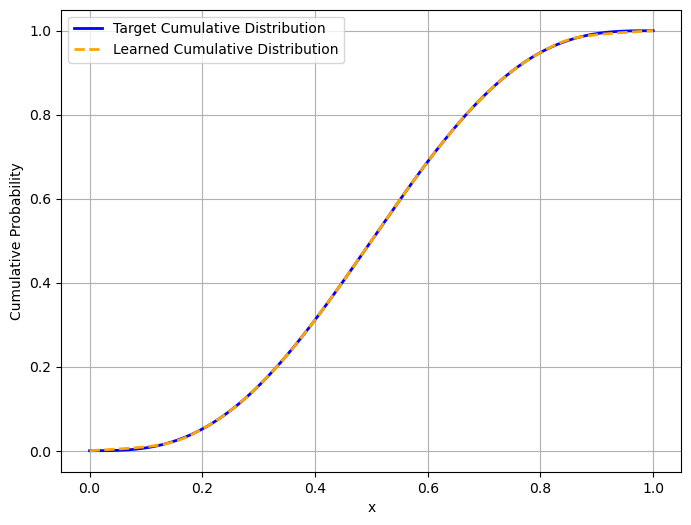

In [12]:
learn_dis(lambda x: beta.cdf(x, 3.2, 3.2))

Loss: 0.000061: 100%|██████████| 10000/10000 [00:21<00:00, 456.18it/s]


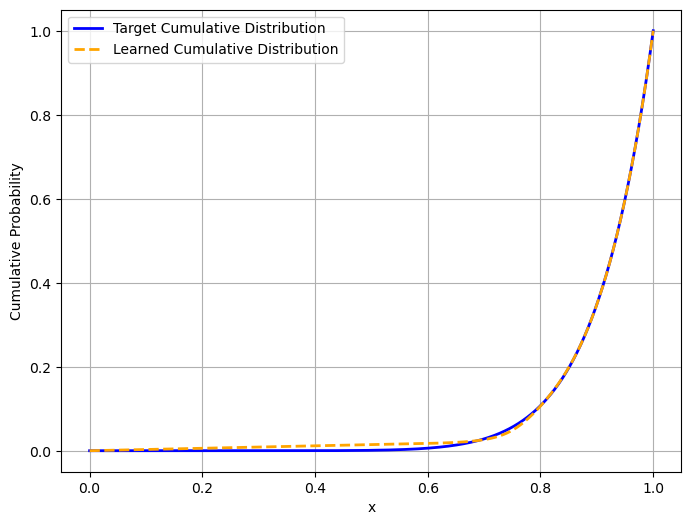

In [13]:
learn_dis(lambda x: beta.cdf(x, 10, 1))

Loss: 0.000000: 100%|██████████| 10000/10000 [00:23<00:00, 425.77it/s]


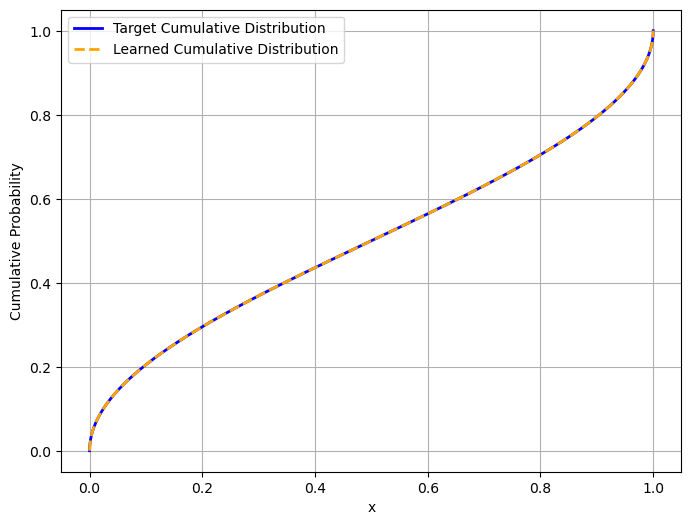

In [14]:
learn_dis(lambda x: beta.cdf(x, 0.5, 0.5))

Loss: 0.000061: 100%|██████████| 10000/10000 [00:22<00:00, 440.04it/s]


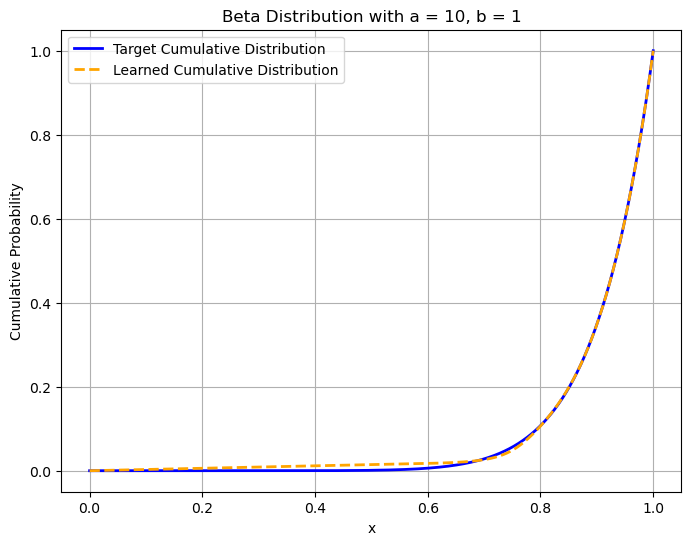

Loss: 0.099223:  12%|█▏        | 1203/10000 [00:03<00:22, 398.28it/s]


KeyboardInterrupt: 

In [15]:
learn_dis(lambda x: beta.cdf(x, 10, 1), title="Beta Distribution with a = 10, b = 1")
learn_dis(lambda x: gamma.cdf(x, 2.0, scale=2.0), title="Gamma Distribution with k = 2.0, scale = 2.0")
learn_dis(lambda x: expon.cdf(x, scale=1.0), title="Exponential Distribution with scale = 1.0")
learn_dis(lambda x: weibull_min.cdf(x, 1.5), title="Weibull Distribution with shape = 1.5")
learn_dis(lambda x: lognorm.cdf(x, s=0.954), title="Log-Normal Distribution with s = 0.954")
learn_dis(lambda x: norm.cdf(x, loc=0, scale=1), title="Normal Distribution with loc = 0, scale = 1")
learn_dis(lambda x: t.cdf(x, df=5), title="Student's t-Distribution with df = 5")
learn_dis(lambda x: pareto.cdf(x, b=2.62), title="Pareto Distribution with b = 2.62")

In [16]:
files = []

for i in glob.glob("data/*.xlsx"):
    data = read_data(i)
    
    # if data.meta.chemical in ["Clothianidin", "Esfenvalerate", "BPS"]:
    files.append(data)
        
        
fits = []
for data in files:
    data : ExperimentData
    for stressor in data.additional_stress:
        
        settings = StandardSettings(survival_max=data.meta.max_survival, len_curves = 1000)

        main_fit = dose_response_fit(data.main_series, settings)

        stress_fit = dose_response_fit(data.additional_stress[stressor], settings)
        
        fits.append((data, stressor, main_fit, stress_fit))
xs, ys = [], []

for data, stressor, main_fit, stress_fit in fits:
    
    main_fit : ModelPredictions
    stress_fit : ModelPredictions
    
    if stress_fit.optim_param["d"] > main_fit.optim_param["d"]:
        print("dropping")
        continue
    
    xs.append(main_fit.survival_curve / data.meta.max_survival)
    
    ys.append(stress_fit.survival_curve / data.meta.max_survival)
    
toxicant_surv = np.array(xs)
stres_surv = np.array(ys)
toxicant_surv.min(), toxicant_surv.max(), stres_surv.min(), stres_surv.max(), toxicant_surv.shape, stres_surv.shape

(0.0001785401417463745,
 0.9999996553904024,
 8.131316489735313e-07,
 0.999999908326523,
 (42, 1000),
 (42, 1000))

In [45]:
N_SAMPLES = 10000
N_PARAMS = 5000
STEPS = 30000
LR = 1e-3
DEVICE = "cuda"
REG_FAC = 0.0


model = LearnableCumDistribution(n_buckets=N_PARAMS)
tox_torch = torch.tensor(toxicant_surv, dtype=torch.float32, device=DEVICE)
stress_torch = torch.tensor(stres_surv, dtype=torch.float32, device=DEVICE)
model = model.to(device=DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=LR)

# Linear LR decay function
lambda_lr = lambda step: 1 - step / STEPS
scheduler = LambdaLR(optim, lr_lambda=lambda_lr)

bar = tqdm(range(STEPS))

for step in bar:
    optim.zero_grad()
    
    tox_stress = model(1- tox_torch)
    stress_stress = model(1- stress_torch)
    
    new_diff = stress_stress - tox_stress
    variance = torch.var(new_diff, dim=1)
    loss = variance.mean()
    
    probs = nn.functional.softmax(model.logits, 0)
    probs_diff = probs[1:] - probs[:-1]
    smoothness_reg = torch.sum(probs_diff ** 2)
    
    loss += smoothness_reg * REG_FAC
    
    loss.backward()
    optim.step()
    
    # Update the learning rate
    scheduler.step()

    bar.set_description(f"Step: {step}, Loss: {float(loss.item()):.10f}, LR: {scheduler.get_last_lr()[0]:.6f}")

Step: 29999, Loss: 0.0008900228, LR: 0.000000: 100%|██████████| 30000/30000 [01:54<00:00, 262.98it/s]


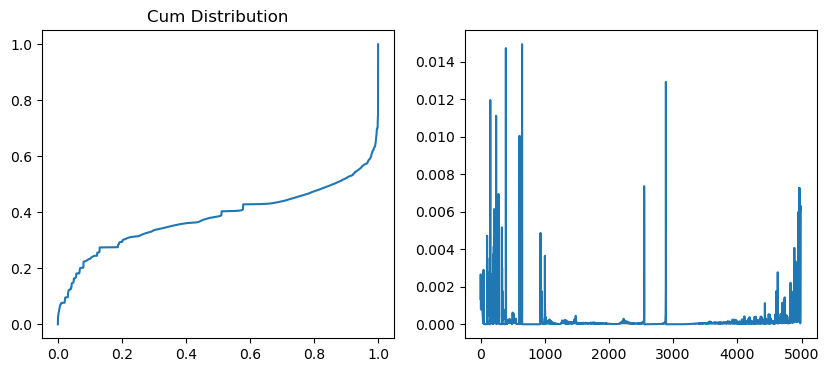

In [46]:
x = np.linspace(0,1, 10000)
y = model(torch.tensor(x, dtype=torch.float32, device=DEVICE)).detach().cpu().numpy()

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(x,y)
plt.title("Cum Distribution")

k = nn.functional.softmax(model.logits, 0).detach().cpu().numpy()[5:-5]

plt.subplot(1,2,2)
plt.plot(k)
plt.show()

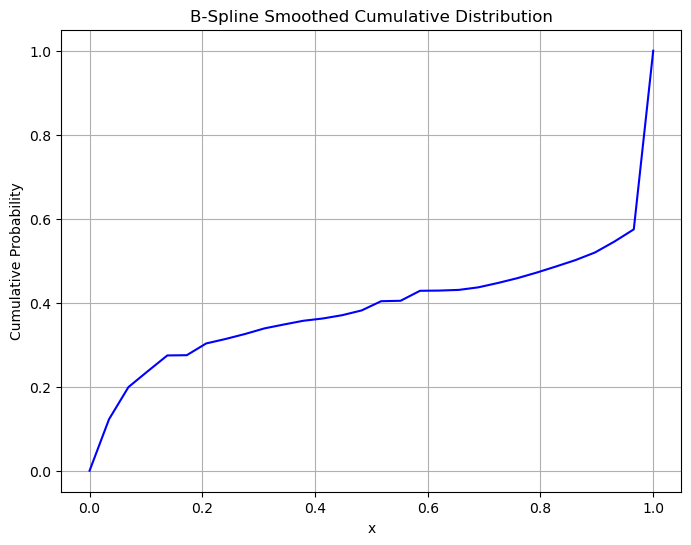

In [47]:
from scipy.interpolate import make_interp_spline
import torch
import numpy as np
import matplotlib.pyplot as plt

# B-Spline smoothing function
def bspline_inference(model, x, device="cuda", smoothing_factor=30):
    x_tensor = torch.tensor(x, dtype=torch.float32, device=device)
    y = model(x_tensor).detach().cpu().numpy()
    
    # B-Spline interpolation
    spl = make_interp_spline(x, y, k=3)  # Cubic B-spline
    x_smooth = np.linspace(x.min(), x.max(), smoothing_factor)
    y_smooth = spl(x_smooth)
    
    return x_smooth, y_smooth

# Generate x values and apply the B-Spline inference function
x = np.linspace(0, 1, 10000)
x_smooth, y_smooth = bspline_inference(model, x, device=DEVICE)

# Plot the smoothed curve
plt.figure(figsize=(8, 6))
plt.plot(x_smooth, y_smooth, label="Smoothed Cumulative Distribution", color='blue')
plt.xlabel("x")
plt.ylabel("Cumulative Probability")
plt.title("B-Spline Smoothed Cumulative Distribution")
plt.grid(True)
plt.show()


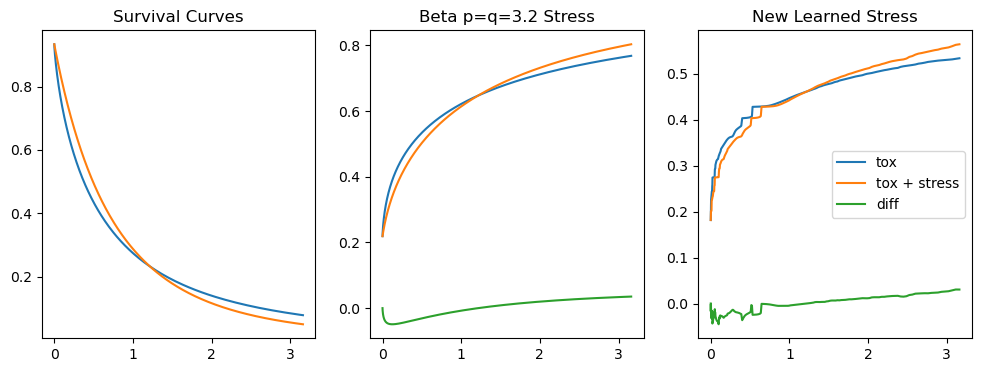

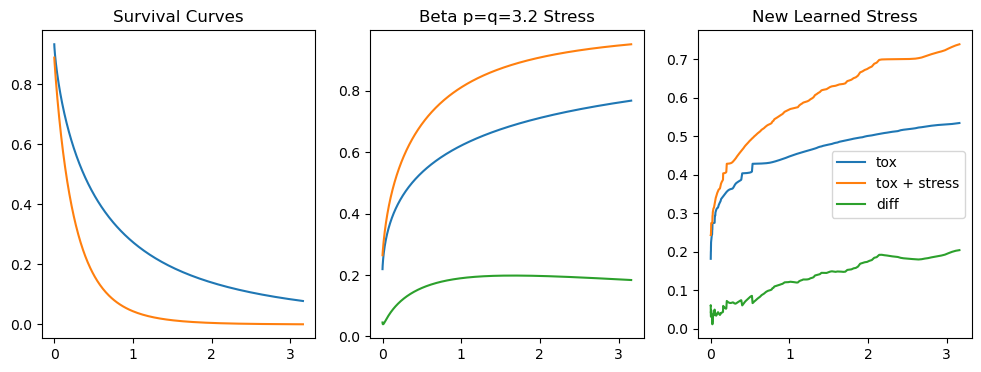

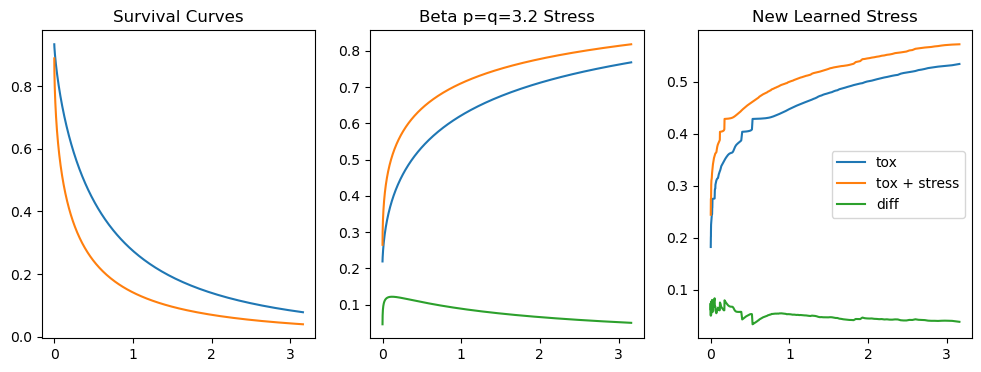

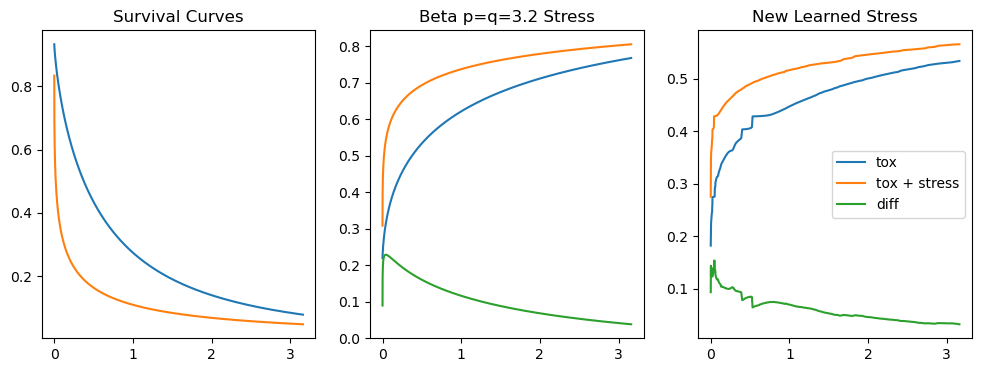

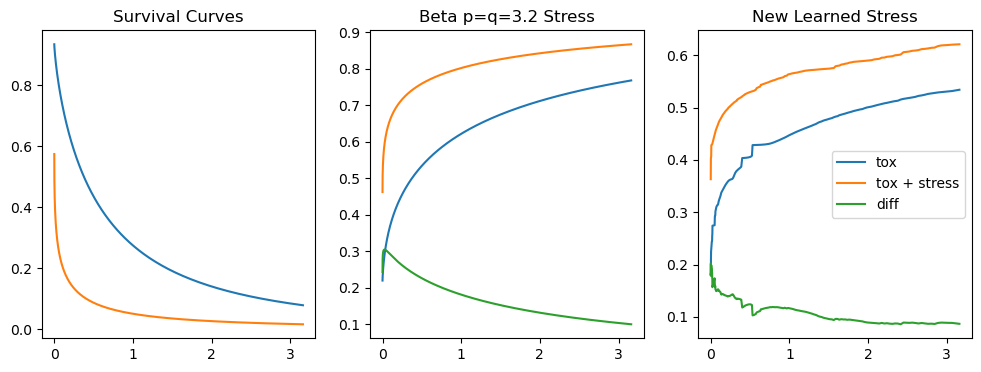

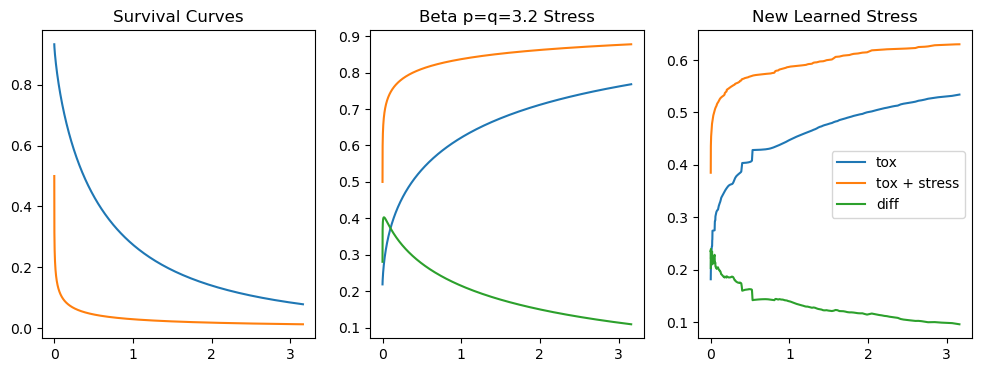

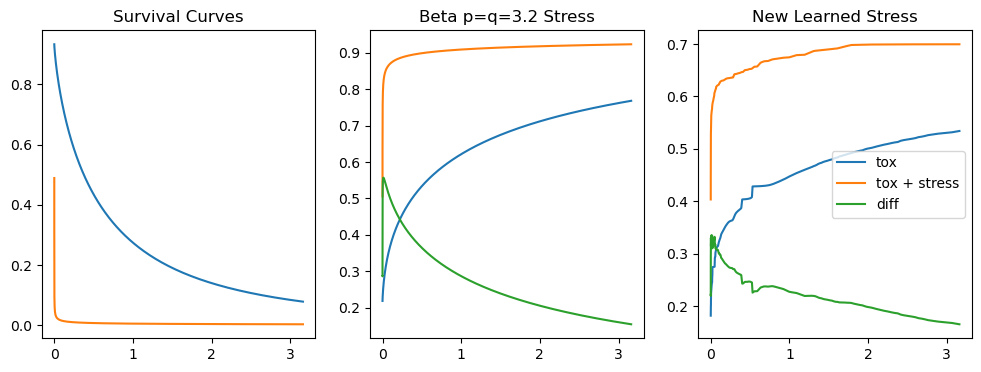

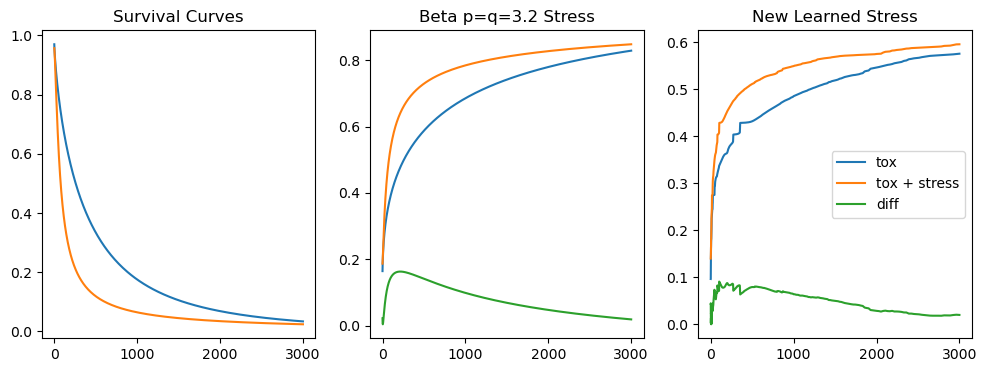

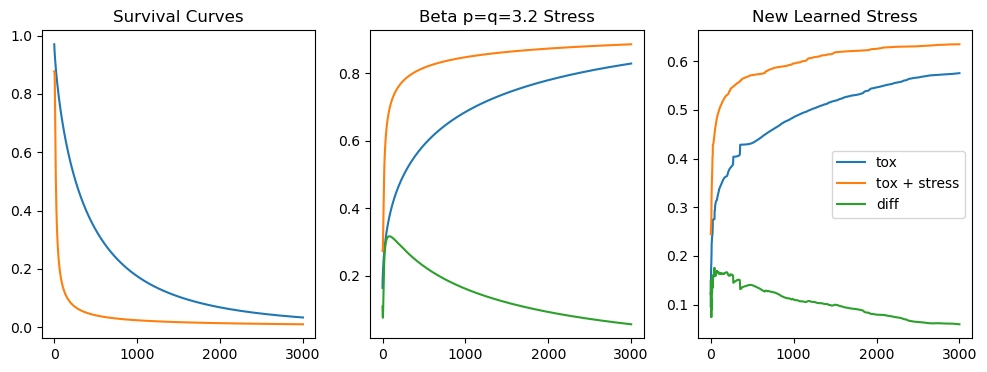

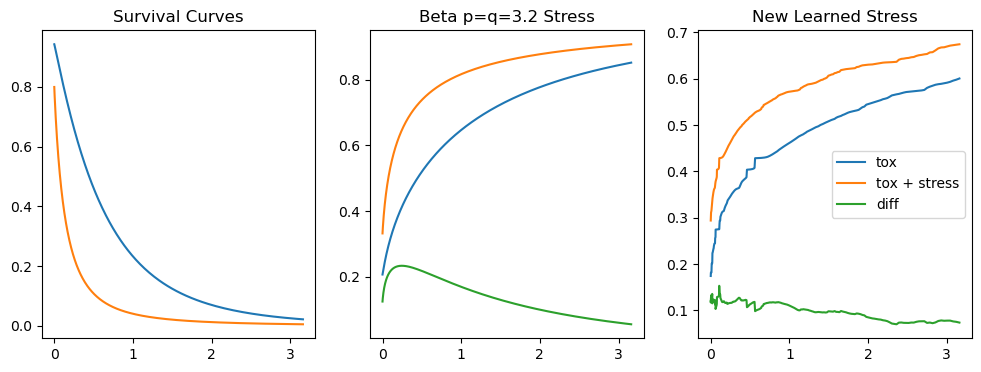

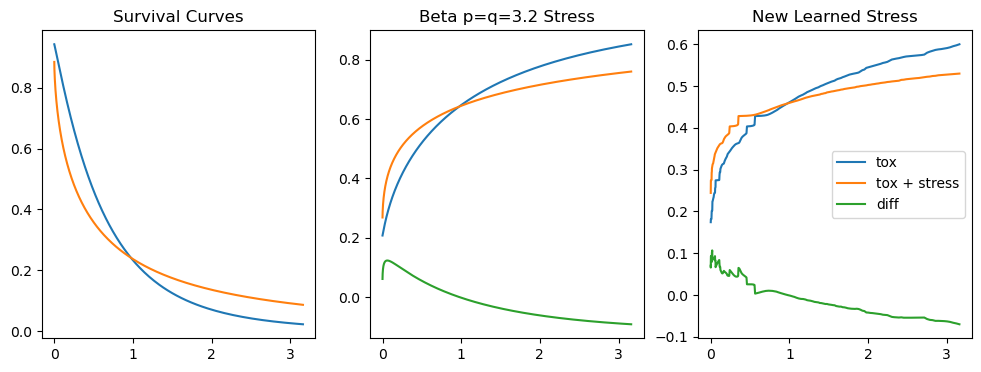

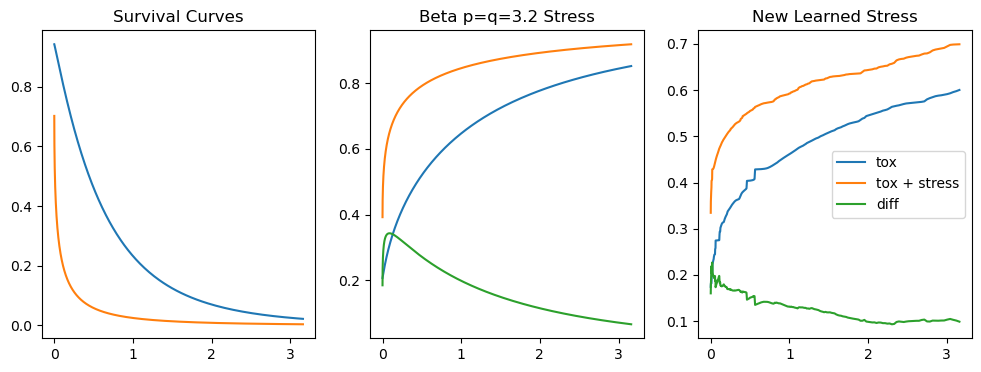

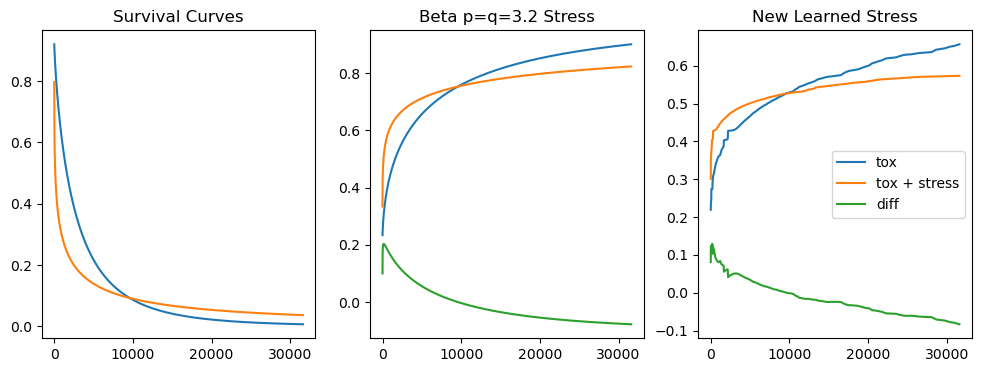

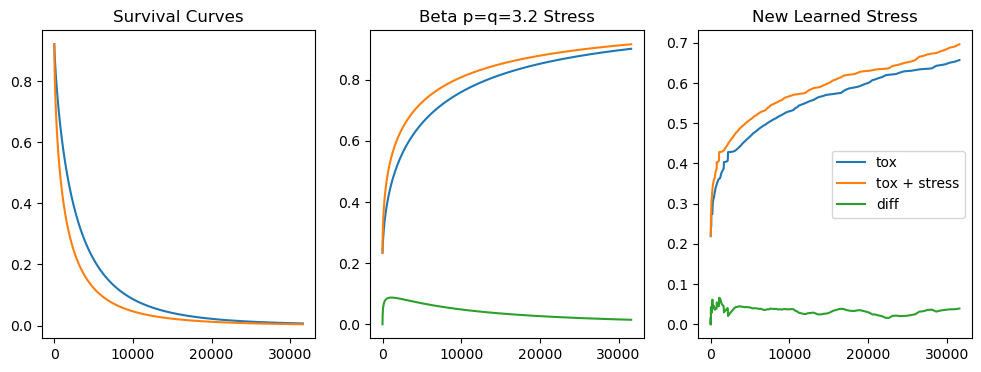

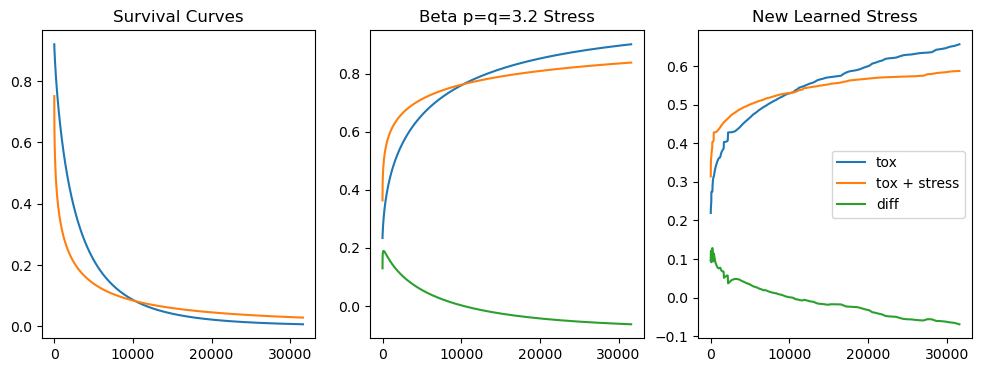

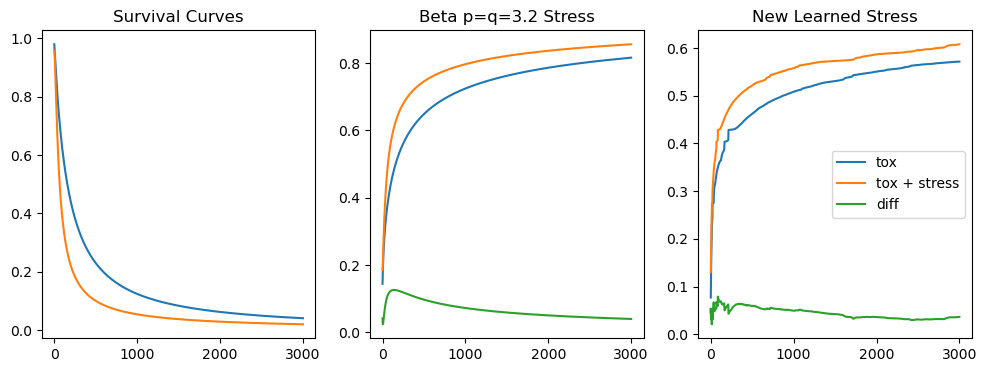

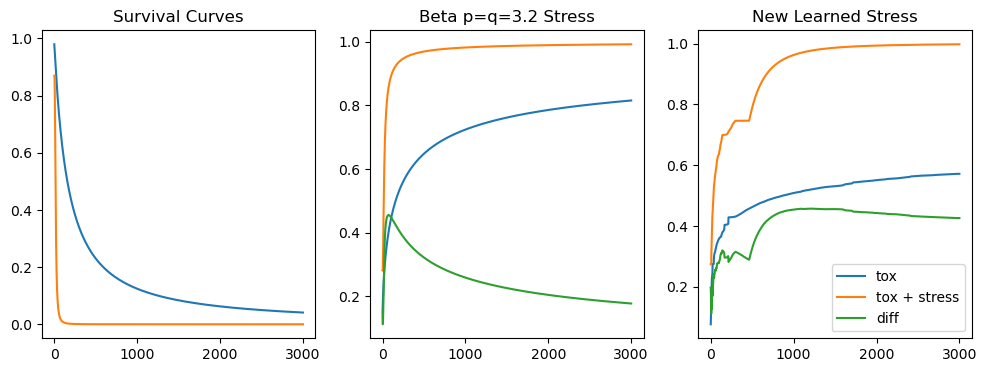

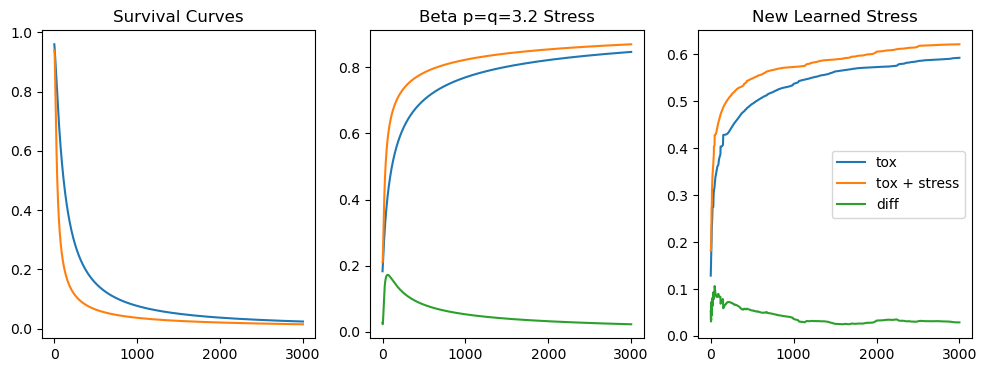

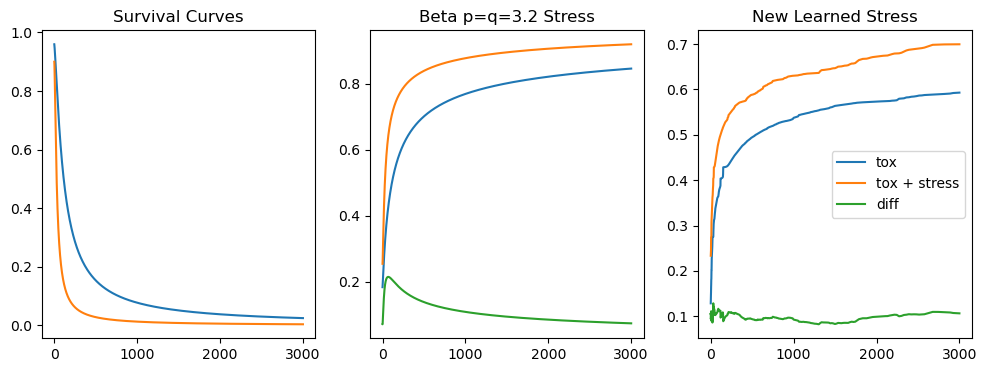

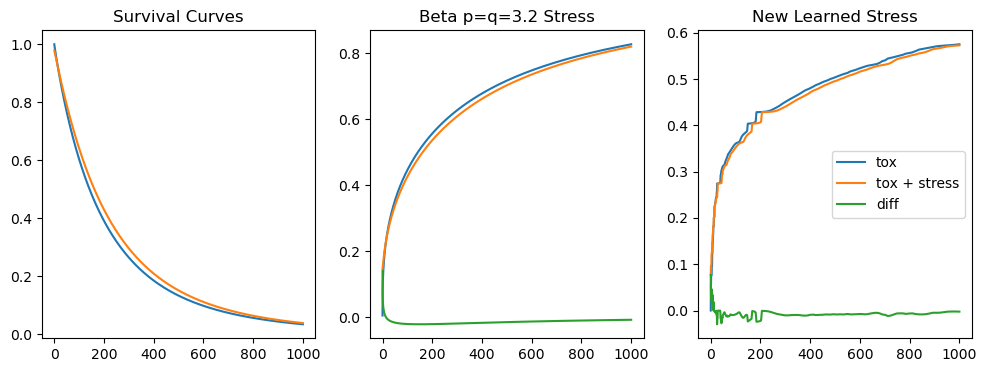

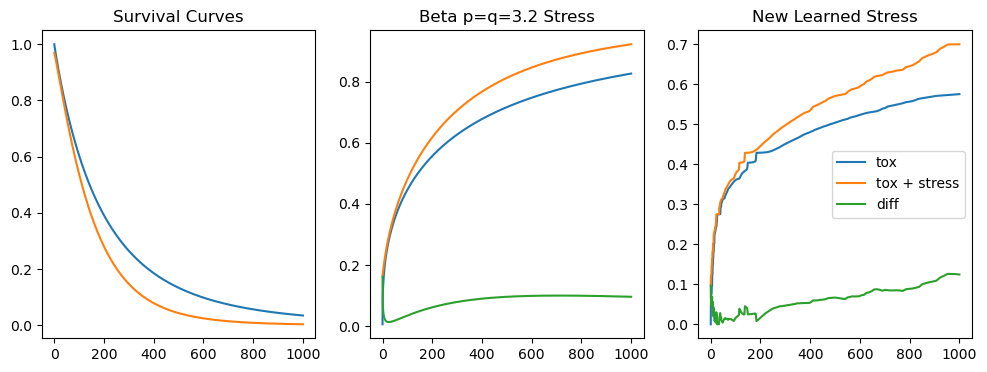

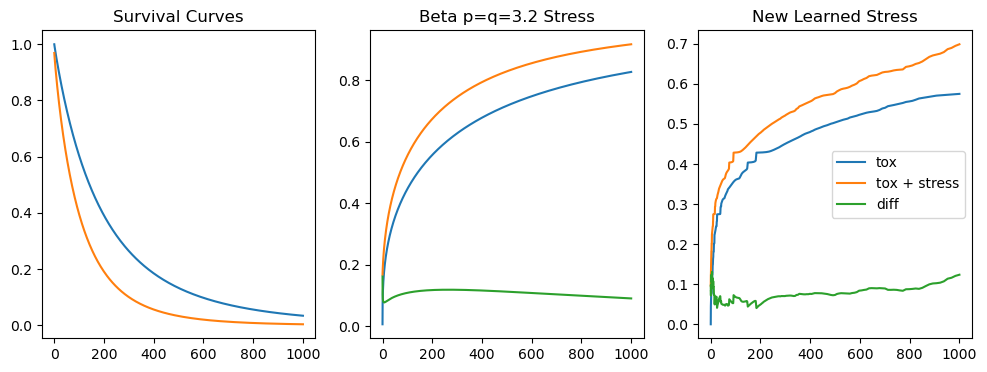

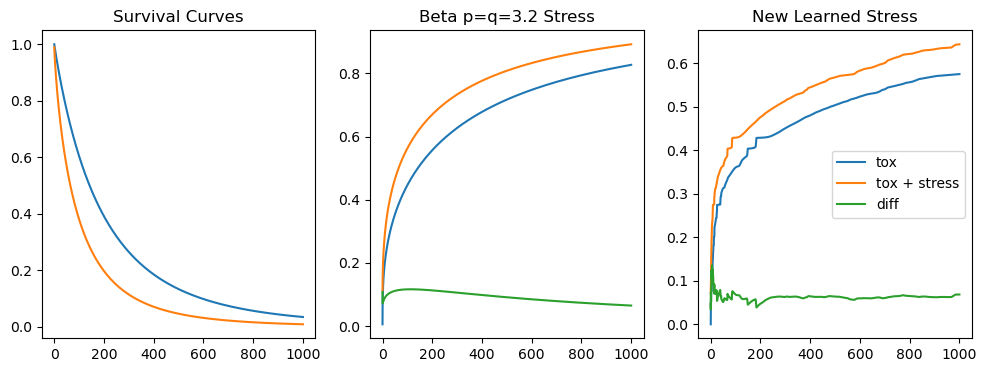

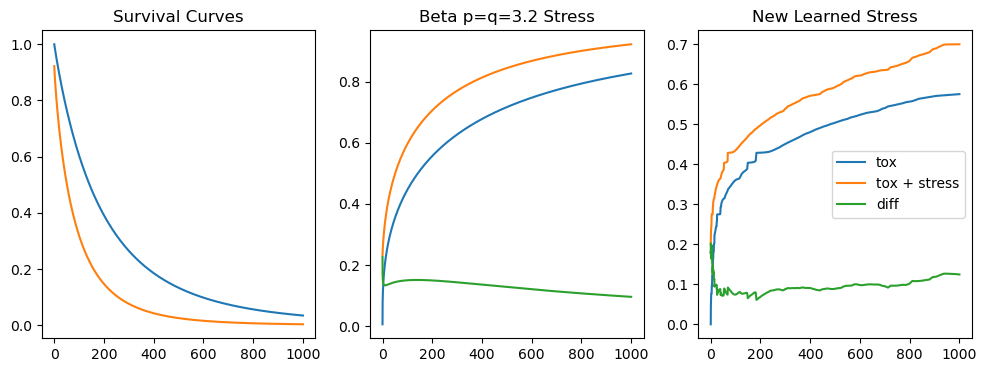

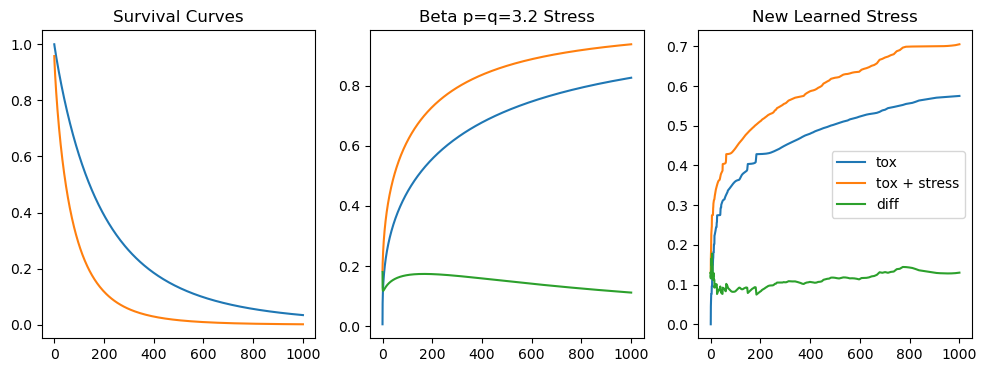

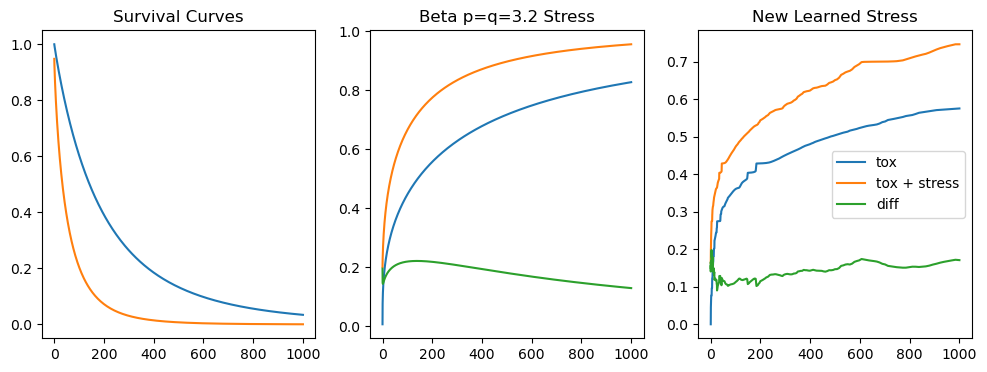

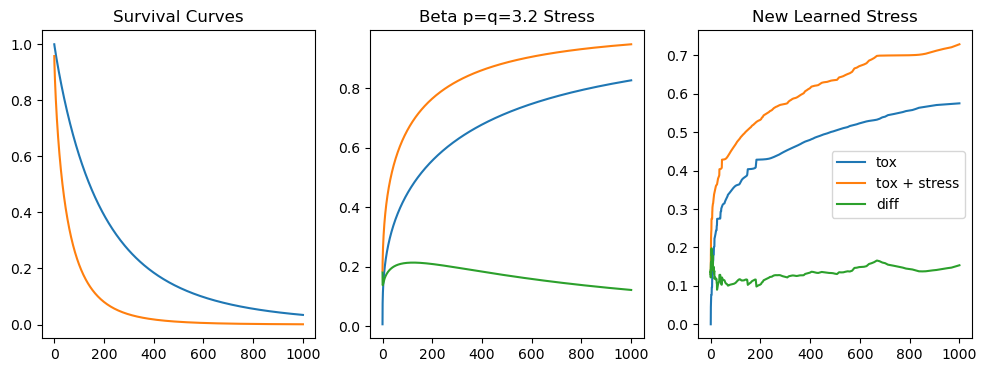

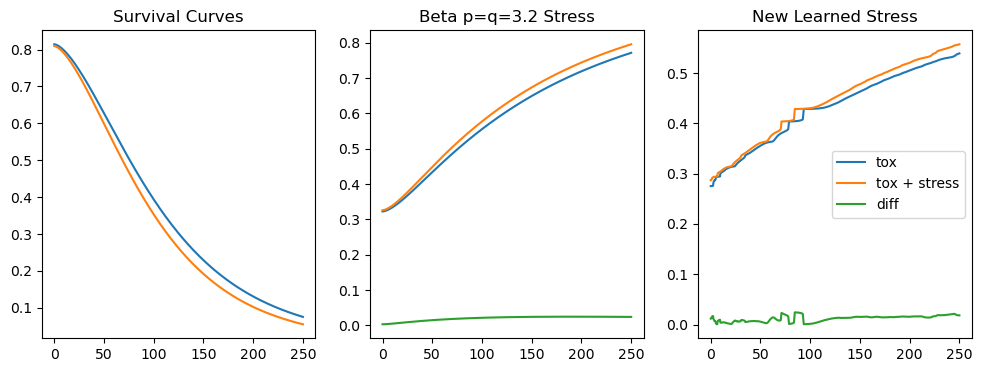

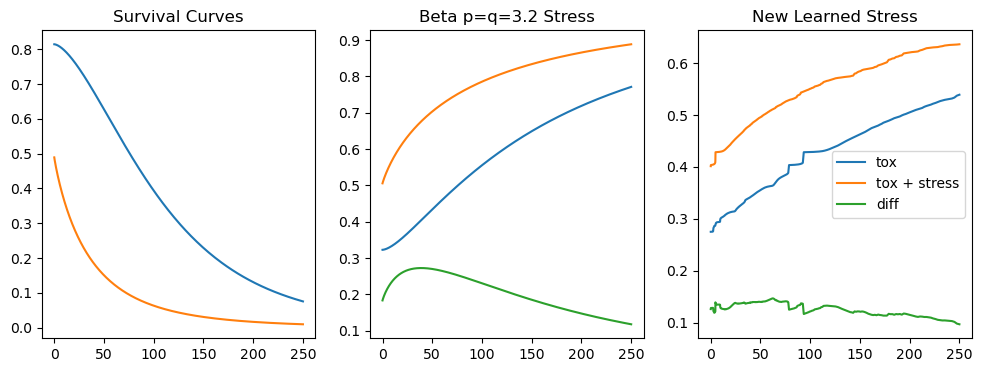

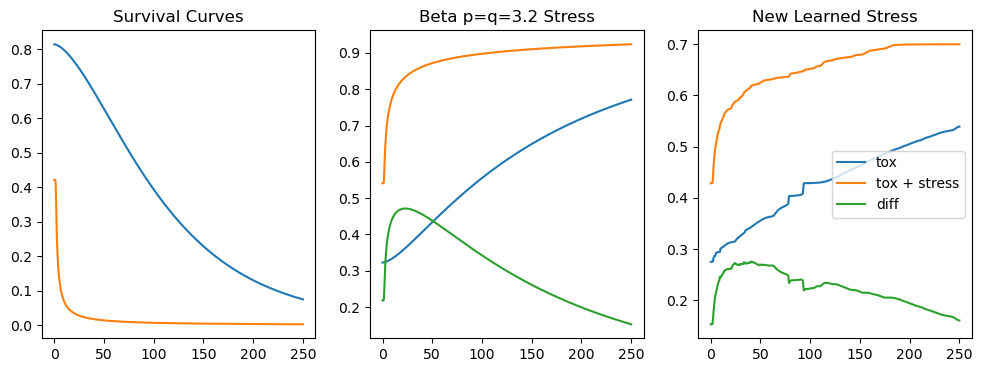

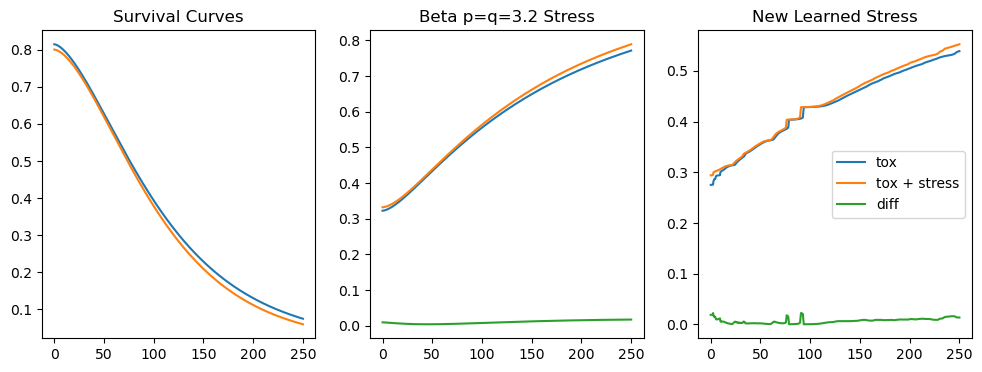

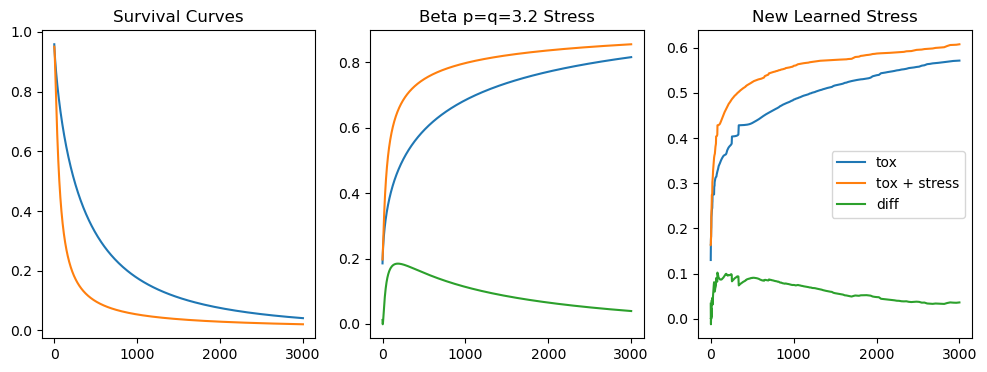

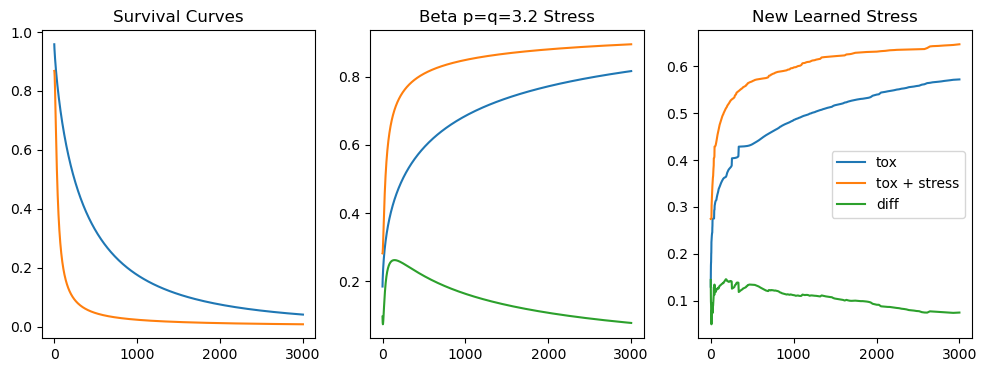

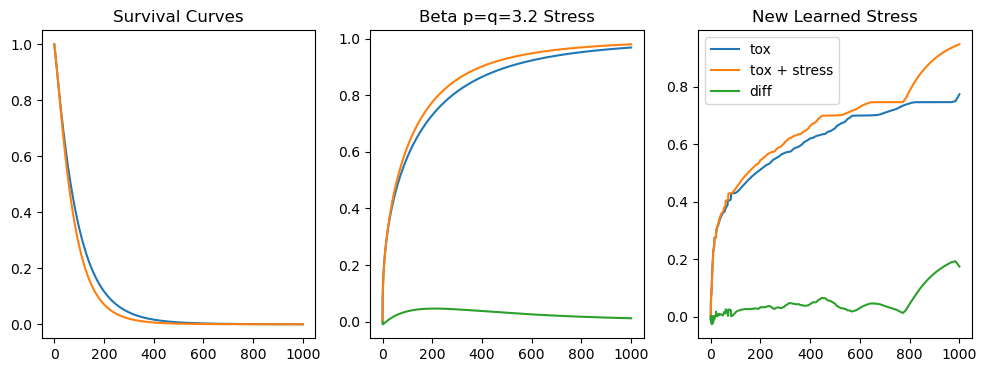

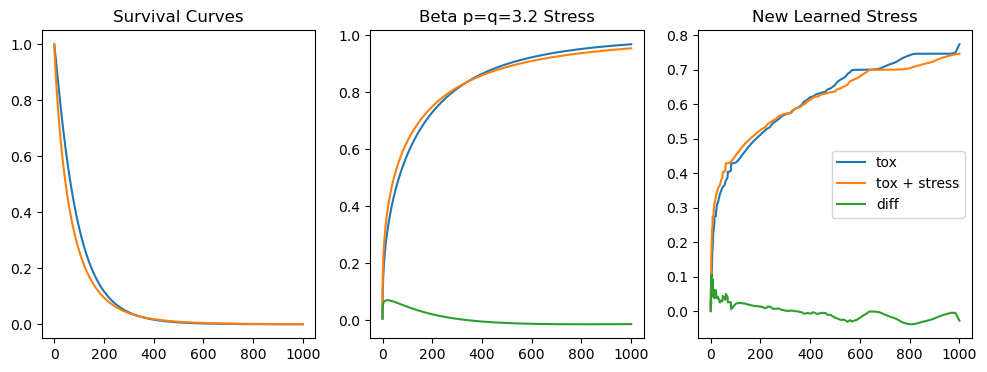

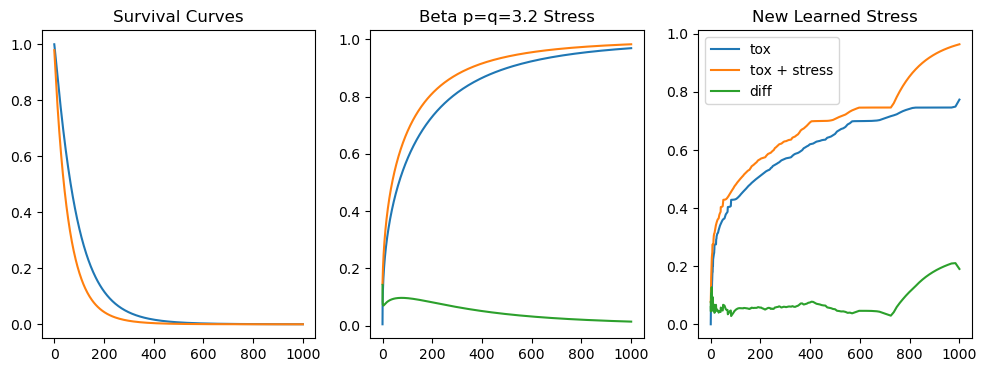

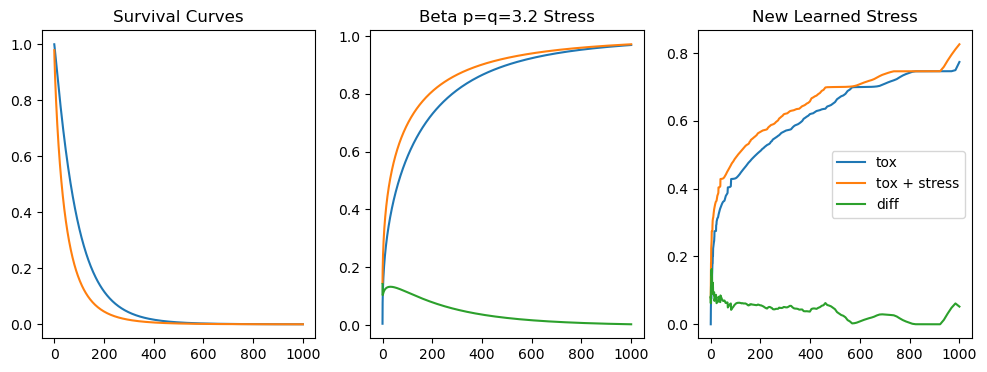

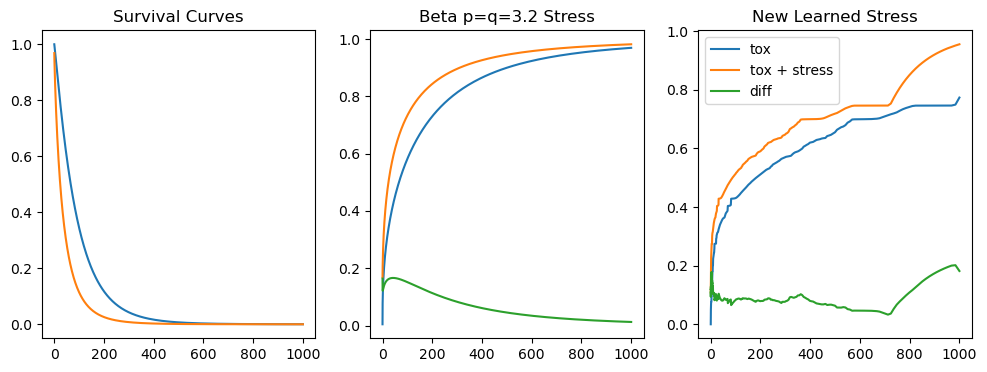

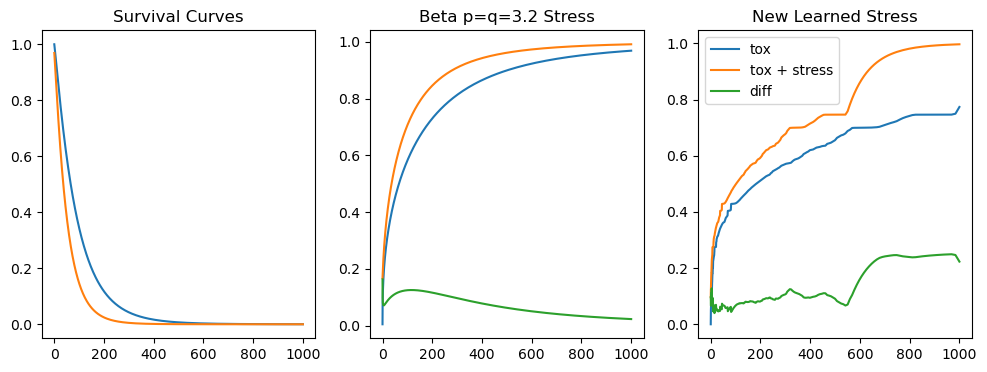

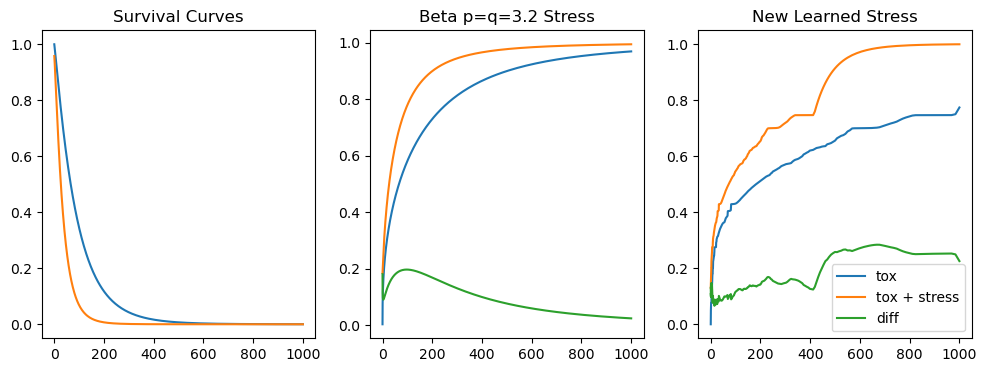

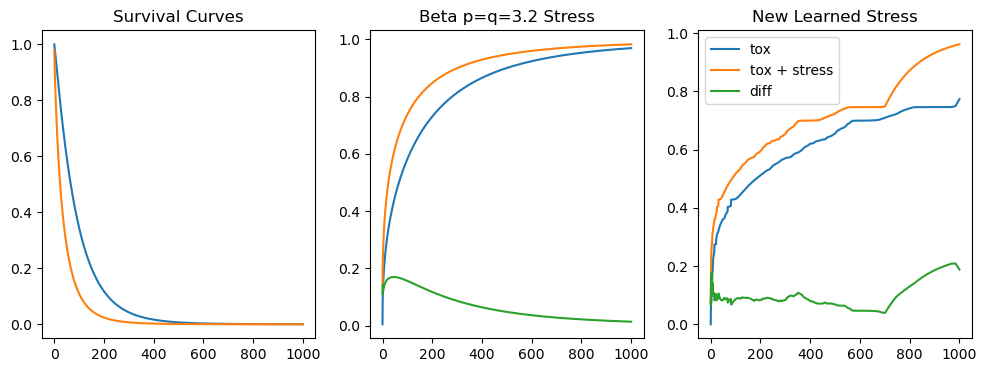

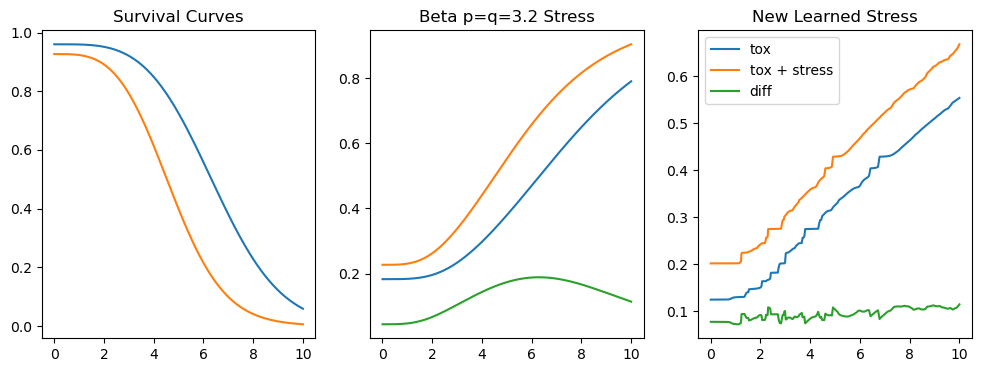

In [48]:
def to_stres_new(x):
    return model(torch.tensor(1 - x, dtype=torch.float32, device=DEVICE)).detach().cpu().numpy()

new_diffs = []
old_diffs = []

for data, stressor, main_fit, stress_fit in fits:
    
    surv = main_fit.survival_curve / data.meta.max_survival
    surv_stress = stress_fit.survival_curve / data.meta.max_survival
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(main_fit.concentration_curve, surv, label = "tox")
    plt.plot(main_fit.concentration_curve, surv_stress, label = "tox + stress")
    plt.title("Survival Curves")
    
    plt.subplot(1,3,2)
    a = survival_to_stress(surv)
    b = survival_to_stress(surv_stress)
    old_diff = b -a 
    
    plt.plot(main_fit.concentration_curve, a, label = "tox")
    plt.plot(main_fit.concentration_curve, b, label = "tox + stress")
    plt.plot(main_fit.concentration_curve, old_diff, label = "diff")
    plt.title("Beta p=q=3.2 Stress")
    old_diffs.append(old_diff)
    
    plt.subplot(1,3,3)
    a = to_stres_new(surv)
    b = to_stres_new(surv_stress)
    new_diff = b -a 
    
    plt.plot(main_fit.concentration_curve, a, label = "tox")
    plt.plot(main_fit.concentration_curve, b, label = "tox + stress")
    plt.plot(main_fit.concentration_curve, new_diff, label = "diff")
    plt.title("New Learned Stress")
    
    
    plt.legend()
    plt.show()
    
    new_diffs.append(new_diff)

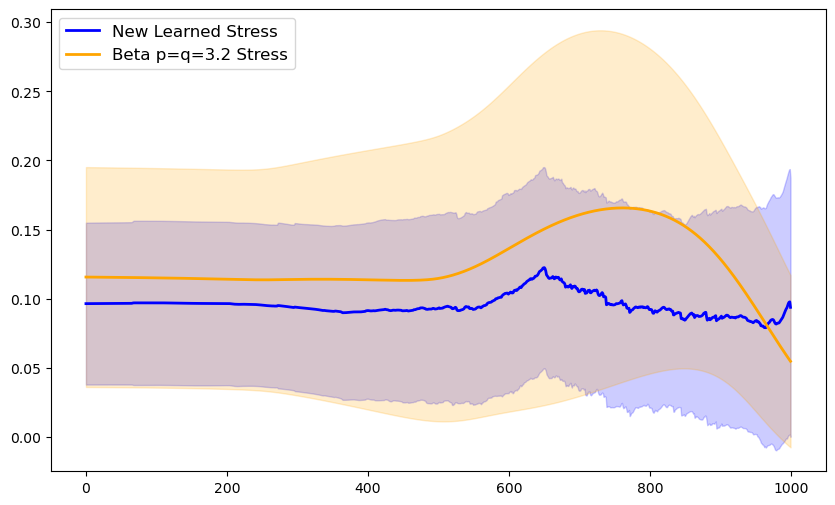

In [49]:
from matplotlib.lines import Line2D

new_means = np.mean(new_diffs, axis=0)
new_stds = np.std(new_diffs, axis=0)
old_means = np.mean(old_diffs, axis=0)
old_stds = np.std(old_diffs, axis=0)


plt.figure(figsize=(10, 6))

# Plot new learned stress with shaded uncertainty
plt.plot(new_means, label="New Learned Stress", color='blue', linewidth=2)
plt.fill_between(np.arange(len(new_means)), new_means - new_stds, new_means + new_stds, color='blue', alpha=0.2)

# Plot beta p=q=3.2 stress with shaded uncertainty
plt.plot(old_means, label="Beta p=q=3.2 Stress", color='orange', linewidth=2)
plt.fill_between(np.arange(len(old_means)), old_means - old_stds, old_means + old_stds, color='orange', alpha=0.2)

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='New Learned Stress'),
    Line2D([0], [0], color='orange', lw=2, label='Beta p=q=3.2 Stress')
]

plt.legend(handles=legend_elements, loc='upper left', fontsize=12)
plt.show()

In [51]:
model.to_df().to_csv("learned_distribution.csv", index=False)

In [ ]:
def sam_pred(main_fit : ModelPredictions, stress_fit : ModelPredictions, )


for data, stressor, main_fit, stress_fit in fits:
    
    surv = main_fit.survival_curve / data.meta.max_survival
    surv_stress = stress_fit.survival_curve / data.meta.max_survival
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(main_fit.concentration_curve, surv, label = "tox")
    plt.plot(main_fit.concentration_curve, surv_stress, label = "tox + stress")
    plt.title("Survival Curves")
    
    plt.subplot(1,3,2)
    a = survival_to_stress(surv)
    b = survival_to_stress(surv_stress)
    old_diff = b -a 
    
    plt.plot(main_fit.concentration_curve, a, label = "tox")
    plt.plot(main_fit.concentration_curve, b, label = "tox + stress")
    plt.plot(main_fit.concentration_curve, old_diff, label = "diff")
    plt.title("Beta p=q=3.2 Stress")
    old_diffs.append(old_diff)
    
    plt.subplot(1,3,3)
    a = to_stres_new(surv)
    b = to_stres_new(surv_stress)
    new_diff = b -a 
    
    plt.plot(main_fit.concentration_curve, a, label = "tox")
    plt.plot(main_fit.concentration_curve, b, label = "tox + stress")
    plt.plot(main_fit.concentration_curve, new_diff, label = "diff")
    plt.title("New Learned Stress")
    
    
    plt.legend()
    plt.show()
    
    new_diffs.append(new_diff)